# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [2]:
import sys
sys.path.insert(0, '/home/nj6532/github/olympus_mons_brieflow/brieflow/workflow')

In [3]:
import sys
print('\n'.join(sys.path))

/home/nj6532/github/olympus_mons_brieflow/brieflow/workflow
/home/nj6532/miniconda3/envs/brieflow_OPS_pilot/lib/python311.zip
/home/nj6532/miniconda3/envs/brieflow_OPS_pilot/lib/python3.11
/home/nj6532/miniconda3/envs/brieflow_OPS_pilot/lib/python3.11/lib-dynload

/home/nj6532/miniconda3/envs/brieflow_OPS_pilot/lib/python3.11/site-packages


In [4]:
from pathlib import Path

import yaml
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt


from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_tile_metadata, nd2_to_tiff
from lib.preprocess.file_utils import get_sample_fps

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [5]:
scratch_analysis = "/scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/"
CONFIG_FILE_PATH = scratch_analysis + "config/config.yml"
ROOT_FP = scratch_analysis + "brieflow_outputs/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample nd2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile, "cycle""` to extract SBS processing information
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phentoype processing information
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern (path and sample) should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- For both path and sample patterns, numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample fil epath should have an associated plate/well. For single plate/well screens manually add a plate/well to the file path dataframe.

In [6]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = scratch_analysis + "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = scratch_analysis + "config/phenotype_samples.tsv"

# paths to combo dataframes
SBS_COMBO_DF_FP = scratch_analysis + "config/sbs_combo.tsv"
PHENOTYPE_COMBO_DF_FP = scratch_analysis + "config/phenotype_combo.tsv"

# Directory, pattern, and metadata for SBS sample nd2 files
SBS_IMAGES_DIR_FP = scratch_analysis + "input_files/sbs/"
SBS_PATH_PATTERN = r"Plate(\d+)_.*?_c(\d+)_.*?_Well([A-Z]\d+)_Tile-(\d+)__.*\.nd2"
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}

# Directory, pattern, and metadata for phenotype sample nd2 files
PHENOTYPE_IMAGES_DIR_FP = scratch_analysis + "input_files/phenotyping/"
PHENOTYPE_PATH_PATTERN = r"Plate(\d+)_.*?_c(\d+)_.*?_Well([A-Z]\d+)_Tile-(\d+)__.*\.nd2" #NJ mod to extract ph round
PHENOTYPE_PATH_METADATA = ["plate", "round", "well", "tile"] #NJ mod to extract ph round
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "round": int} #NJ mod to extract ph round

You must supply a working regex to the `SBS_PATH_PATTERN` and `PHENOTYPE_PATH_PATTERN` variables. If you don't have experience with regex, you can use the following LLM prompt to generate the patterns.

*Enter into a basic LLM chatbot*: 

Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example sbs filenames: **[ENTER YOUR EXAMPLE SBS FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Example phenotype filenames: **[ENTER YOUR EXAMPLE PHENOTYPE FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Required regex patterns (return these exact variable assignments):
```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:
1. SBS pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")
     - Cycle number (after "/c")
2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

Also provide the corresponding metadata lists and variable types:
```python
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

Example patterns for reference:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"

SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]

SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

## Create Sample DFs

In [7]:
sbs_samples = create_samples_df(
    SBS_IMAGES_DIR_FP, SBS_PATH_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE
)
sbs_wildcard_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
# Save and display sample dataframe
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)
sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
print("SBS wildcard combos:")
display(sbs_wildcard_combos)

# Create sample dataframe for phenotype

phenotype_samples = create_samples_df(
    PHENOTYPE_IMAGES_DIR_FP,
    PHENOTYPE_PATH_PATTERN,
    PHENOTYPE_PATH_METADATA,
    PHENOTYPE_METADATA_ORDER_TYPE,
)
phenotype_wildcard_combos = (
    phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
)
# Save and display sample dataframe
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)
phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
print("Phenotype wildcard combos:")
display(phenotype_wildcard_combos)

SBS samples:


sample_fp  plate well  tile  \
0      /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
1      /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
2      /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
3      /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
4      /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
...                                                  ...    ...  ...   ...   
66039  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3   675   
66040  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3   675   
66041  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3   675   
66042  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3   675   
66043  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3   675   

       cycle  
0          1  
1          2  
2          3  
3          4  
4          5  
...      ...  
66039      7  
66040      8  
66041      9  
66042     10  
66043     11  

[66044 rows x 5 columns]

SBS wildcard combos:


plate cycle well tile
0         1     1   A1    0
1         1     2   A1    0
2         1     3   A1    0
3         1     4   A1    0
4         1     5   A1    0
...     ...   ...  ...  ...
66039     2     7   A3  675
66040     2     8   A3  675
66041     2     9   A3  675
66042     2    10   A3  675
66043     2    11   A3  675

[66044 rows x 4 columns]

Phenotype samples:


sample_fp  plate well  tile  \
0       /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
1       /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
2       /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
3       /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
4       /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      1   A1     0   
...                                                   ...    ...  ...   ...   
168879  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3  2782   
168880  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3  2782   
168881  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3  2782   
168882  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3  2782   
168883  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...      2   A3  2782   

        round  
0           1  
1           2  
2           3  
3           4  
4           5  
...       ...  
168879      2  
168880      3  
168881      4  
168882      5  
168883      6  

[168884 rows x 5 columns]

Phenotype wildcard combos:


plate round well  tile
0          1     1   A1     0
1          1     2   A1     0
2          1     3   A1     0
3          1     4   A1     0
4          1     5   A1     0
...      ...   ...  ...   ...
168879     2     2   A3  2782
168880     2     3   A3  2782
168881     2     4   A3  2782
168882     2     5   A3  2782
168883     2     6   A3  2782

[168884 rows x 4 columns]

## Test Metadata Extraction

In [8]:
if SBS_IMAGES_DIR_FP is not None:
    # Extract metadata from test sbs sample
    test_sbs_metadata = extract_tile_metadata(
        sbs_samples["sample_fp"][0],
        sbs_samples["plate"][0],
        sbs_samples["well"][0],
        sbs_samples["tile"][0],
        verbose=True,
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Extract metadata from test phenotype sample
    test_phenotype_metadata = extract_tile_metadata(
        phenotype_samples["sample_fp"][0],
        phenotype_samples["plate"][0],
        phenotype_samples["well"][0],
        phenotype_samples["tile"][0],
        verbose=True,
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Processing tile 0 from file /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/input_files/sbs/Plate1_10X_c1_SBS_WellA1_Tile-0__Channel405_SBS_fast,75Screen_G_532_565-24,75Screen_T_594_615-20,75Screen_A_640_676-37,75Screen_C_640_785-62.nd2
File shape: (5, 2048, 2048)
Number of dimensions: 3
Data type: uint16
Sizes (by axes): {'C': 5, 'Y': 2048, 'X': 2048}
SBS test metadata:


x_pos    y_pos        z_pos pfs_offset  plate well  tile  \
0  32612.8 -36234.1  6631.118847       None      1   A1     0   

                                            filename  channels  pixel_size_x  \
0  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...         5          0.65   

   pixel_size_y  
0          0.65

Processing tile 0 from file /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/input_files/phenotyping/Plate1_20X_c1_phenotyping_WellA1_Tile-0__Channel640_L34E100,405_L7p5_E50.nd2
File shape: (2, 2048, 2048)
Number of dimensions: 3
Data type: uint16
Sizes (by axes): {'C': 2, 'Y': 2048, 'X': 2048}
Phenotype test metadata:


x_pos    y_pos        z_pos pfs_offset  plate well  tile  \
0  28590.7 -33763.6  6565.736574       None      1   A1     0   

                                            filename  channels  pixel_size_x  \
0  /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil -...         2         0.325   

   pixel_size_y  
0         0.325

## <font color='red'>SET PARAMETERS</font>

### ND2 conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [ ]:
SBS_CHANNEL_ORDER = None
PHENOTYPE_CHANNEL_ORDER = None
PHENOTYPE_ROUND_ORDER = [1,2,3,4,5,6,7]

In [10]:
SBS_CHANNEL_ORDER_FLIP = None
PHENOTYPE_CHANNEL_ORDER_FLIP = True

## Test ND2 Conversion

### Test SBS conversion

Processing file 1/1: /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/input_files/sbs/Plate1_10X_c1_SBS_WellA1_Tile-0__Channel405_SBS_fast,75Screen_G_532_565-24,75Screen_T_594_615-20,75Screen_A_640_676-37,75Screen_C_640_785-62.nd2
Original dimensions for /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/input_files/sbs/Plate1_10X_c1_SBS_WellA1_Tile-0__Channel405_SBS_fast,75Screen_G_532_565-24,75Screen_T_594_615-20,75Screen_A_640_676-37,75Screen_C_640_785-62.nd2: ('C', 'Y', 'X')
Array shape after processing: (5, 2048, 2048)
Final dimensions (CYX): (5, 2048, 2048)
Converted SBS test sample:


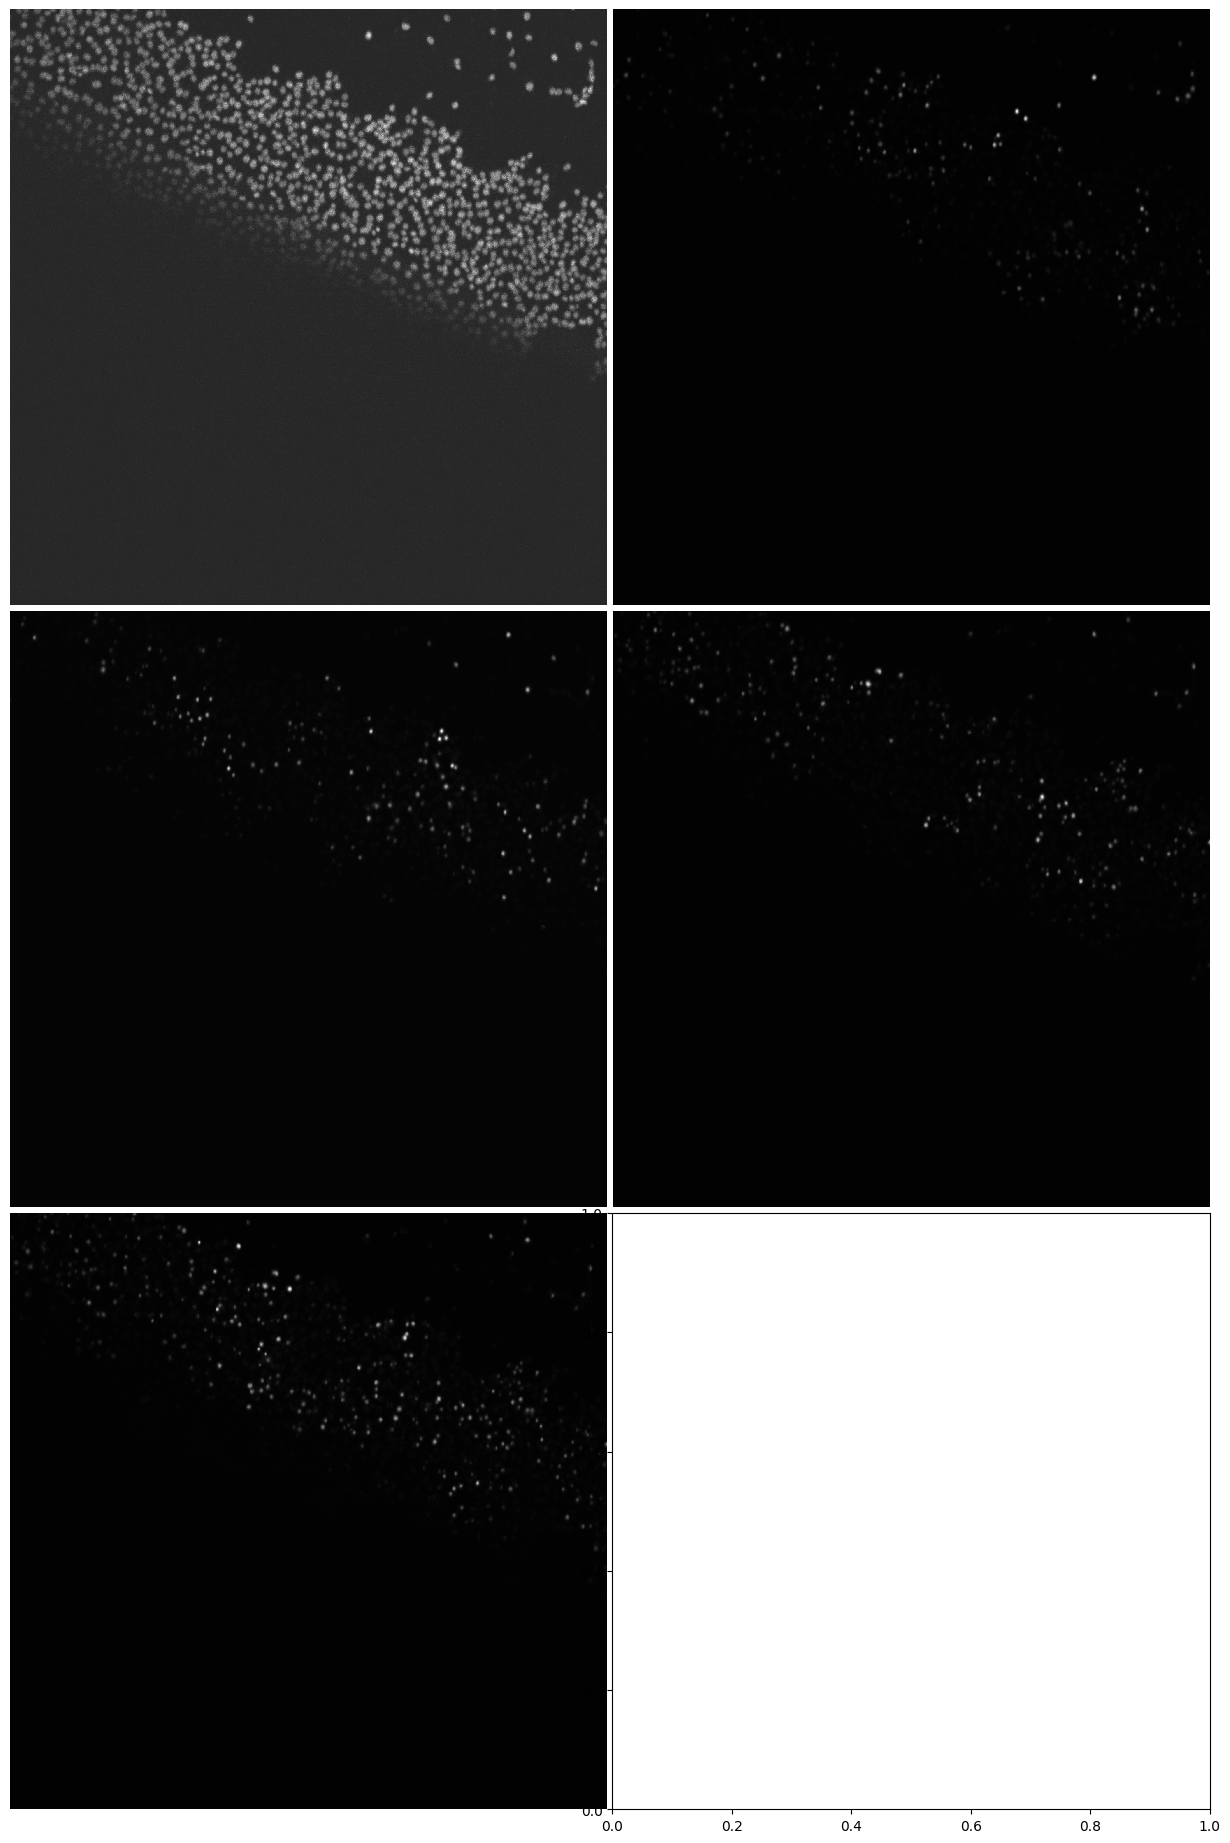

In [11]:
if SBS_IMAGES_DIR_FP is not None:
    # Get test sbs sample
    sbs_sample = get_sample_fps(
        sbs_samples,
        plate=sbs_samples["plate"][0],
        well=sbs_samples["well"][0],
        tile=sbs_samples["tile"][0],
        cycle=sbs_samples["cycle"][0],
        channel_order=SBS_CHANNEL_ORDER,
    )

    # Convert test sbs sample to tiff
    sbs_image = nd2_to_tiff(sbs_sample, SBS_CHANNEL_ORDER_FLIP, verbose=True)
    # Create micropanel to display converted samples
    print("Converted SBS test sample:")
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.show()

### Test phenotype conversion

Processing file 1/7: /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/input_files/phenotyping/Plate1_20X_c1_phenotyping_WellA1_Tile-0__Channel640_L34E100,405_L7p5_E50.nd2
Original dimensions for /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/input_files/phenotyping/Plate1_20X_c1_phenotyping_WellA1_Tile-0__Channel640_L34E100,405_L7p5_E50.nd2: ('C', 'Y', 'X')
Array shape after processing: (2, 2048, 2048)
Processing file 2/7: /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/input_files/phenotyping/Plate1_20X_c2_phenotyping_WellA1_Tile-0__Channel640_L34E100,405_L7p5_E50.nd2
Original dimensions for /scratch/gpfs/BRANGWYNNE/users/Shared/Nikhil - Nima/Olympus_mons_brieflow/analysis/input_files/phenotyping/Plate1_20X_c2_phenotyping_WellA1_Tile-0__Channel640_L34E100,405_L7p5_E50.nd2: ('C', 'Y', 'X')
Array shape after processing: (2, 2048, 2048)
Processing file 3/7: /scratch/gpfs/BRANGWYNNE/us

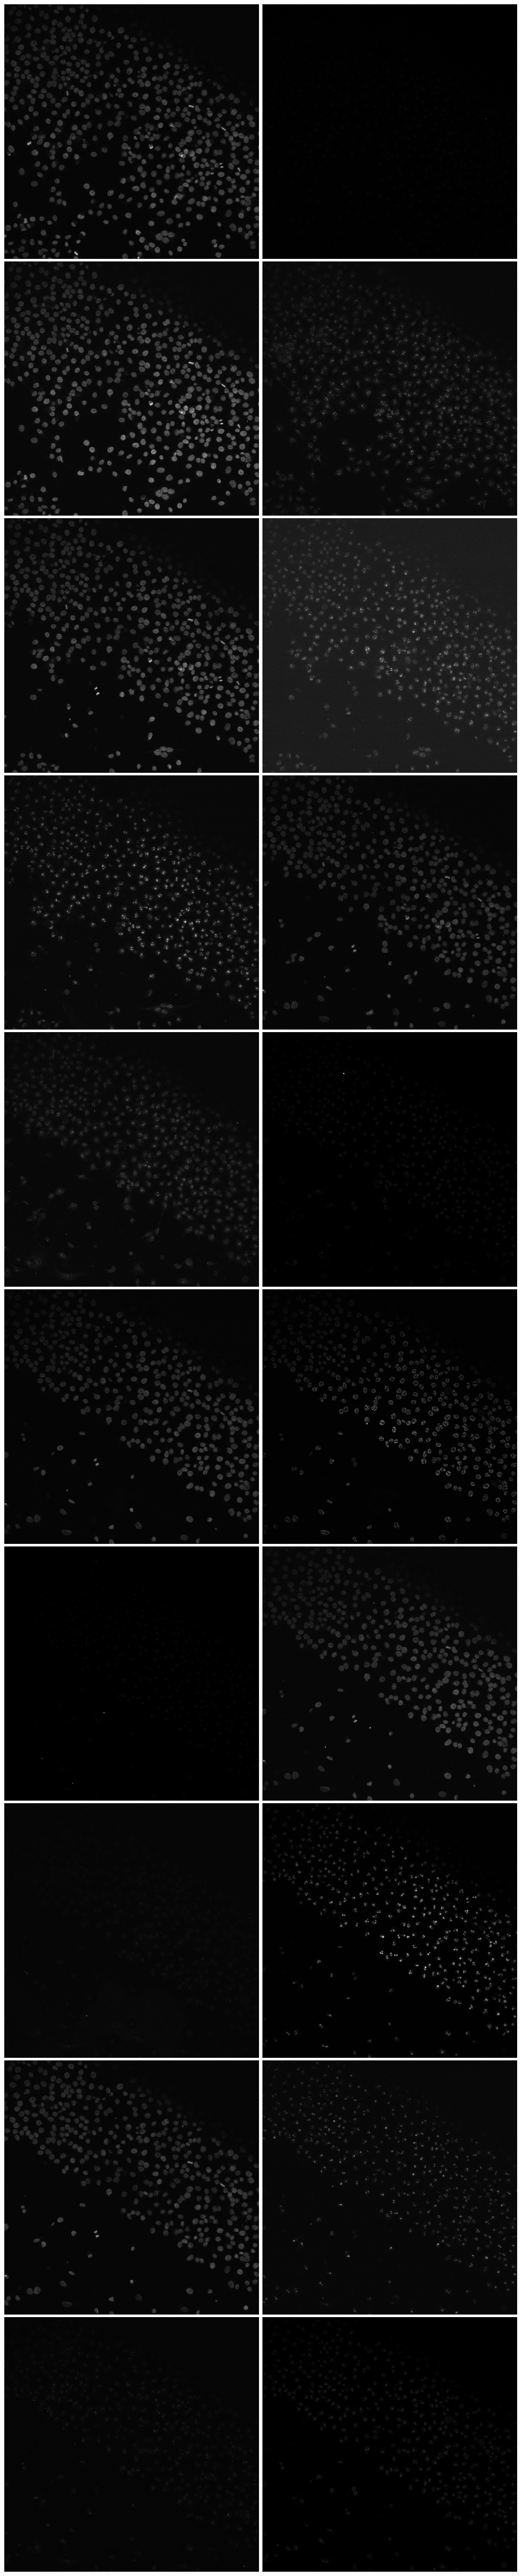

In [12]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=phenotype_samples["plate"][0],
        well=phenotype_samples["well"][0],
        tile=phenotype_samples["tile"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
    )
    # Convert test phenotype sample to tiff
    phenotype_image = nd2_to_tiff(
        phenotype_sample, PHENOTYPE_CHANNEL_ORDER_FLIP, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Calculate illumination correction field

- `SAMPLE_FRACTION`: Controls what percentage of images to use when calculating the illumination correction field (0.0-1.0). Using a smaller fraction (e.g., 0.2 = 20%) speeds up processing by randomly sampling only a subset of your images. Default is 1.0 (use all images). For reliable results, ensure your sample contains enough images to accurately represent illumination variation.

In [38]:
SAMPLE_FRACTION = 1.0

## Create config file with params

In [39]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "phenotype_combo_fp": PHENOTYPE_COMBO_DF_FP,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
    "sample_fraction": SAMPLE_FRACTION,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)